<a href="https://colab.research.google.com/github/ennioVisco/bayesformal/blob/master/analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trajectories analysis for Bayes-Formal project
In what follows, a set of utilities for transforming, plotting and analyzing the data can be found.
There are currently three sources of data:

*   The *real data* comming from measuring the mobile traffic.
*   The *predicted crowdedness* resulting from the Bayesian prediction
* The *satisfaction* and *robustness* traces resulting from the monitoring process, may them be aggregated by the Statistical Model Checking process, or analyzed independently.



## Settings

In [119]:
# Global settings that might be used by all the scripts
plt.rcParams.update({'font.size': 20})  # plots' font size

# Absolute Path
abs_path = "https://raw.githubusercontent.com/ennioVisco/bayesformal/master/"
monitoring_dir = "output/"
resources_dir = "src/main/resources/"
default_path = abs_path + monitoring_dir

# Directories taken into account for loading/storing results
data_dir = "CARar_3_steps_ahead"
chart_dir = "charts"

# Interesting time-points for multi-figure plotting
interesting_snaps = [1, 49, 111] # T = 0:00, 8:00, 19:10

# Aggregated trajectories files taken into account 
# for average and variance robustness
avg_files = [ "r_p1_avg_K500_smc_grid_21x21_T_144"
            , "r_p2_avg_K500_smc_grid_21x21_T_144"
            , "r_p3_avg_K500_smc_grid_21x21_T_144"
            , "r_p4_avg_K500_smc_grid_21x21_T_144" ]
var_files = [ "r_p1_var_K500_smc_grid_21x21_T_144"
            , "r_p2_var_K500_smc_grid_21x21_T_144"
            , "r_p3_var_K500_smc_grid_21x21_T_144"
            , "r_p4_var_K500_smc_grid_21x21_T_144" ]



## Preliminaries

In [120]:
# Load the libraries with usual aliases

# Basics
import numpy as np
from numpy import inf
import pandas as pd 
import xarray as xr
import os, glob
import imageio

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import matplotlib.animation as animation
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator, MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Extras
!pip install qnorm
import qnorm


In [121]:
def plot_graph(filename, directory=data_dir, path=default_path, 
               index="", func=lambda x: x):
  """
  This function plots a chart, given some trajectory loaded from a csv file.
  ...
  Parameters
  ----------
  filename : str
      The name of the file to load
  directory : str, optional
      The directory from which the file will be loaded
  path : str, optional
      The path from which the file will be loaded
  index : str, optional
      The column-indentifier over which the data will be indexed
  func : lambda, optional
      A lambda that will be executed on the fetched data, before plotting
  """
  data = pd.read_csv(path + directory + "/" + filename + ".csv")
  if index != "":
      data = data.set_index(index)
  data = func(data)
  fig = plt.figure()
  fig.suptitle(filename)
  fig.set_size_inches(20,10)
  plt.imshow(data.values, aspect='auto')
  plt.colorbar()
  plt.show()

In [122]:
def plot_multi(filenames, func=lambda x: x, directory=data_dir, path=default_path, 
               maxcols=2, width=20, height=10):
  """
  This function plots multiple charts, given some trajectories loaded 
  from a set of csv files. Indexed over a set of "Spaces"
  ...
  Parameters
  ----------
  filenames : dict(str)
      The name of the files to load
  func : lambda, optional
      A lambda that will be executed on each fetched dataset, before plotting
  directory : str, optional
      The directory from which the file will be loaded
  path : str, optional
      The path from which the file will be loaded
  maxcols : int, optional
      Number of columns to consider for the multi-plot 
      (rows are determined automatically)
  width : int, optional
      Width of the produced set of charts
  height : int, optional
      height of the produced set of charts
  """
  # Data Preparation
  nrows = - (- len(filenames) // maxcols)
  d = list(map(lambda x: pd.read_csv(path + directory + "/" + x + ".csv").set_index("Space"), filenames))
  d = list(map(func, d))
  dmin = min(map(lambda y: y.min().min(), d))
  dmax = max(map(lambda x: x.max().max(), d))
  
  # Figure Generation
  plt.figure(1)
  fig, axes = plt.subplots(nrows, maxcols)
  i = 0
  for data, ax in zip(d, axes.ravel()):
      ax.set_title(filenames[i])
      im = ax.imshow(data.values, aspect='auto', vmin=dmin, vmax=dmax)
      divider = make_axes_locatable(ax)
      cax = divider.append_axes("right", size="20%", pad=0.05)
      cbar = plt.colorbar(im, cax=cax, format="%.2f")
      i = i + 1
  fig.set_size_inches(width, height)
  plt.show()

In [123]:
def generate_gif(filename, path=default_path, input_dir=data_dir, out_dir=chart_dir):
  """
  This function saves a gif, given a csv time-based trajectory file. 
  ...
  Parameters
  ----------
  filenames : dict(str)
      The name of the files to load
  path : str, optional
      The path from which the file will be loaded
  input_dir : str, optional
      The directory from which the file will be loaded
  output_dir : str, optional
      The directory to which the gif will be stored
  """
  df = pd.read_csv(path + input_dir + "/" + filename + ".csv")
  
  dmin = df.drop("Space", axis=1).replace([np.inf, -np.inf], 0).to_numpy().min()
  dmax = df.drop("Space", axis=1).replace([np.inf, -np.inf], 0).to_numpy().max()
  
  # Data refactoring
  data = []
  for j in range(1, 141):
      dfs = []
      i = 0
      for i in range(0, 21): 
          dfs.append(df.iloc[(21 * i):(21 * i + 21), j:(j + 1)].to_numpy())

      dfs = np.asarray(dfs)
      data.append(np.reshape(dfs, (21, 21)))
      
  with plt.rc_context({'font.size': 16}):
      # Plots with Fixed colorbar    
      for i in np.arange(140):
          plt.figure()
          plt.title(filename + '\nTime point: ' + str(i), pad="10")
          plt.imshow(data[i], origin='lower', vmin=dmin, vmax=dmax), plt.colorbar()
          plt.savefig(out_dir + '/temp/' + 'snap_' + str(i) + '_' + filename + '.png')

  snap1 = glob.glob(out_dir + '/temp/' + 'snap_[0-9]_' + filename + '.png') 
  snap2 = glob.glob(out_dir + '/temp/' + 'snap_[0-9][0-9]_' + filename + '.png')
  snap3 = glob.glob(out_dir + '/temp/' + 'snap_[0-9][0-9][0-9]_' + filename + '.png')
  snaps = snap1 + snap2 + snap3

  fix = [imageio.imread(file) for file in snaps]

  imageio.mimsave(out_dir + '/movie_' + filename + '.gif', fix, fps = 3)

In [124]:
def multi_snap_printer(filename, snaps, directory=data_dir, path=default_path, 
                       maxcols=3, width=0.05, left=0.85, 
                       smin=0, smax=0, cmap='', symmetric=False):
  """
  This function plots a multi-snapshot chart, given a csv trajectory file. 
  ...
  Parameters
  ----------
  filenames : dict(str)
      The name of the files to load
  snaps : dict(int)
      The set of snapshot to consider for the multi-plot
  directory : str, optional
      The directory from which the file will be loaded
  path : str, optional
      The path from which the file will be loaded
  maxcols : int, optional
      Number of columns to consider for the multi-plot 
      (rows are determined automatically)
  width : double, optional
      Width of the produced set of charts
  left : double, optional
      left padding of the horizontal legend
  smin : double, optional
      Minimum boundary to which exceeding data will be flattened
  smax : double, optional
      Maximum boundary to which exceeding data will be flattened
  cmap : str, optional
      Colormap to consider for the plots
  symmetric : bool, optional
      Makes adaptations to show a symmetric scale for the plot
  """
  df = pd.read_csv(path + directory + '/' + filename + ".csv")

  # Data refactoring
  d = []
  for j in snaps:
    dfs = []
    i = 0
    for i in range(0, 21): 
      dfs.append(df.iloc[(21 * i):(21 * i + 21), j:(j + 1)].to_numpy())

    dfs = np.asarray(dfs)
    d.append(np.reshape(dfs, (21, 21)))
  
  d2 = np.nan_to_num(d, neginf=0, posinf=0)
  dmax = max(list(map(lambda x: x.max(), d2)))
  dmin = max(list(map(lambda x: x.min(), d2)))
  if(abs(dmax) > abs(dmin) and symmetric):
    dmin = - dmax
  elif(symmetric):
    dmax = - dmin
  #print("MAX:" + str(dmax) + "| MIN:" + str(dmin))
  if smin != 0:
    dmin = smin
    d = np.nan_to_num(d, neginf=smin)
  if smax != 0:
    dmax = smax
    d = np.nan_to_num(d, posinf=smin)
  
  # Grid Ticks
  major_ticks = np.arange(4.5, 20, 5)
  minor_ticks = np.arange(0.5, 20, 1)

  # Figure
  plt.figure(1)
  if maxcols != 1:
    fig, axes = plt.subplots(1, maxcols)
    i = 0
    for data, ax in zip(d, axes.ravel()):
      ax = _helper(data, snaps, ax, i, fig, dmin, dmax, cmap, 
                    major_ticks, minor_ticks, width, left)
      fig.set_size_inches(20, 5)
      i = i + 1
  else: 
    fig, axes = plt.subplots(1, 1)
    axes = _helper(d[0], snaps, axes, 0, fig, dmin, dmax, cmap, 
                    major_ticks, minor_ticks, width, left)
    fig.set_size_inches(6, 5)
  
  plt.show()
    
def _helper(data, snaps, ax, n, fig, dmin, dmax, cmap, 
            major_ticks, minor_ticks, width, left):
  hour = (snaps[n] - 1) // 6
  minutes = ((snaps[n] - 1) % 6) * 10
  if minutes == 0:
      minutes = "00"
  #ax.set_title("snap_t" + str(snaps[i]-1) + '_' + filename)
  if cmap == '':
      im = ax.imshow(data, origin='lower', aspect='auto', vmin=dmin, vmax=dmax)
  else:
      im = ax.imshow(data, origin='lower', aspect='auto', vmin=dmin, vmax=dmax, cmap=cmap)

  ax.set_title("Clock Time: " + str(hour) + ":" + str(minutes), pad="10")
  ax.set_xticks(major_ticks)
  ax.set_xticks(minor_ticks, minor=True)
  ax.set_yticks(major_ticks)
  ax.set_yticks(minor_ticks, minor=True)
  ax.set_ylim(bottom=-0.5)
  ax.set_xlim(left=-0.5)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.grid(which='major', color='#000000', linestyle='--')
  ax.grid(which='minor', color='#CCCCCC', linestyle=':')
  fig.subplots_adjust(right=0.8)
  cbar_ax = fig.add_axes([left, 0.15, width, 0.7])
  fig.colorbar(im, cax=cbar_ax)
  
  return ax

## Basic Plotting

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x288 with 0 Axes>

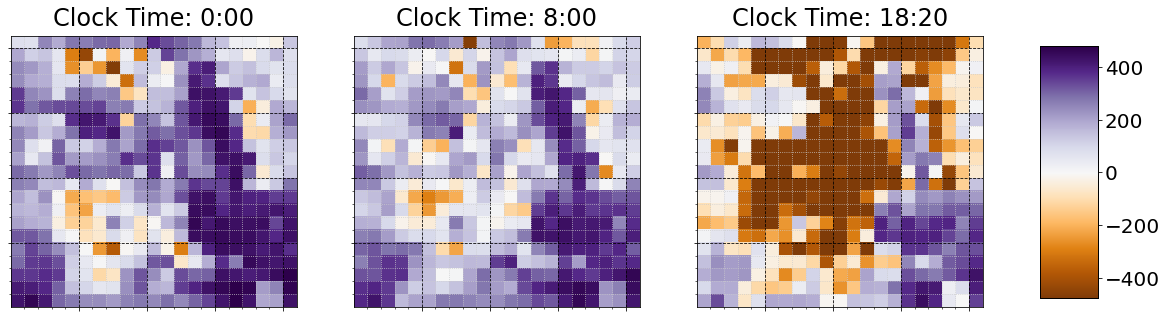

<Figure size 432x288 with 0 Axes>

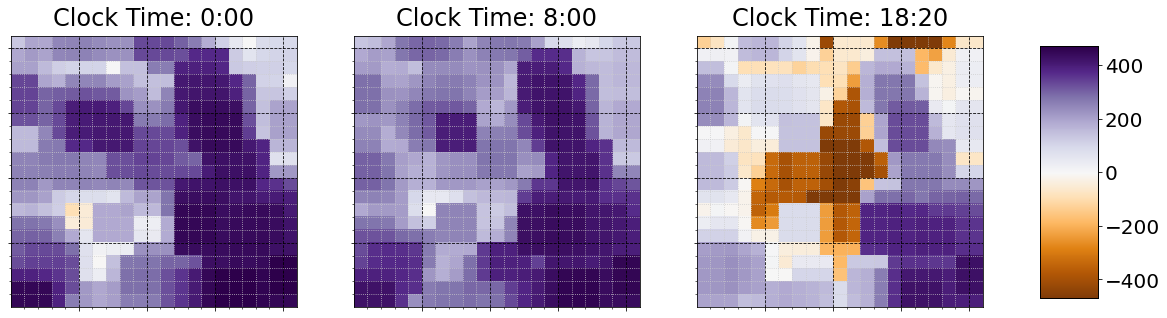

<Figure size 432x288 with 0 Axes>

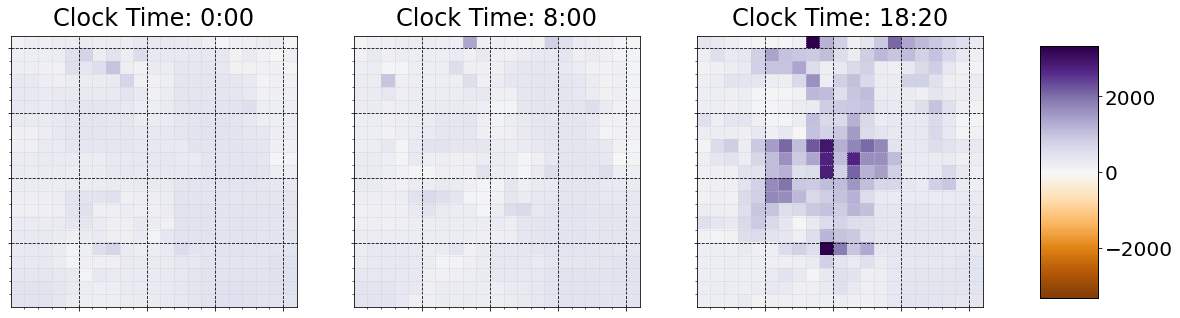

<Figure size 432x288 with 0 Axes>

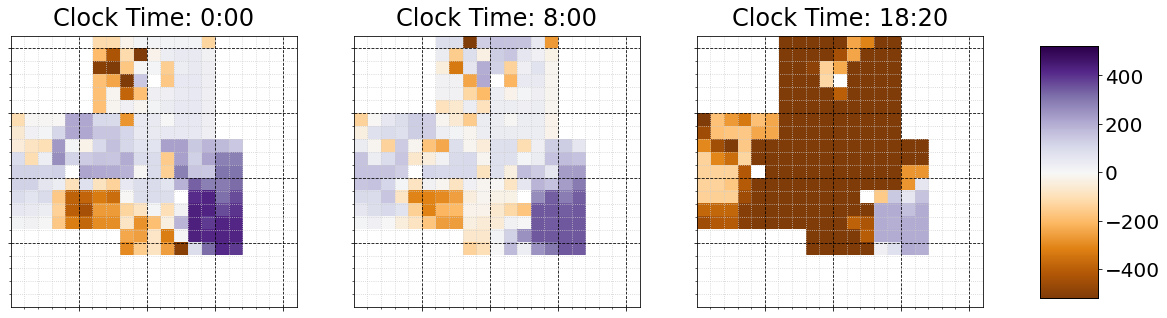

In [129]:
# Plotting Robustness for properties P1-P4
for f in avg_files:
  multi_snap_printer(f, interesting_snaps, width=0.040, left=0.84, cmap='PuOr', symmetric=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x288 with 0 Axes>

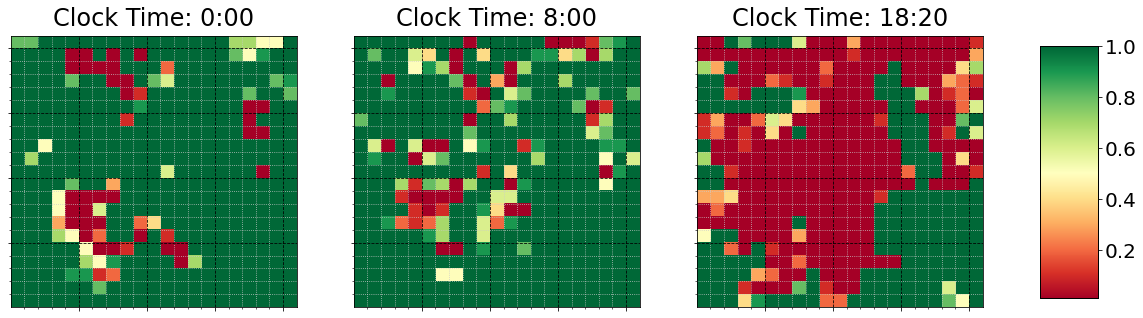

<Figure size 432x288 with 0 Axes>

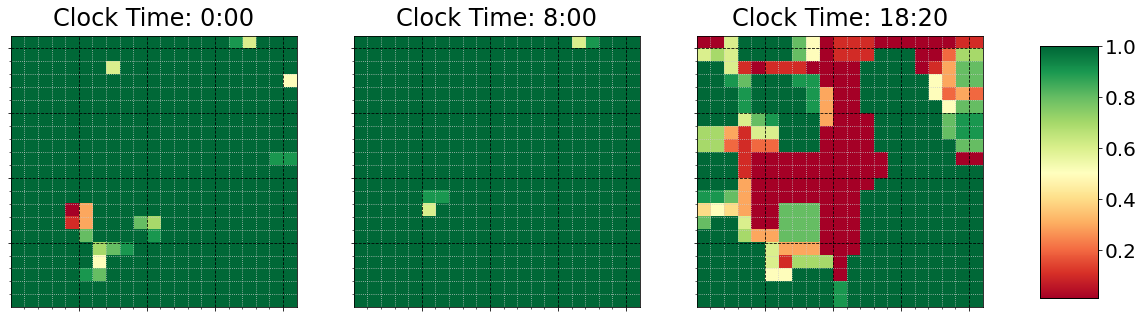

<Figure size 432x288 with 0 Axes>

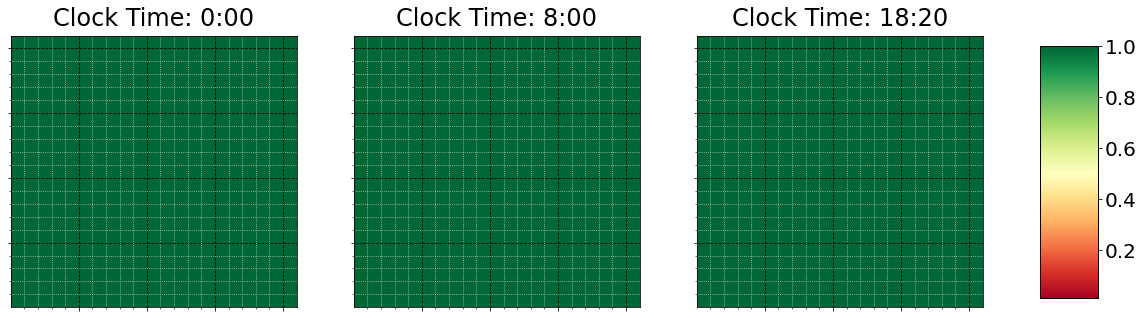

<Figure size 432x288 with 0 Axes>

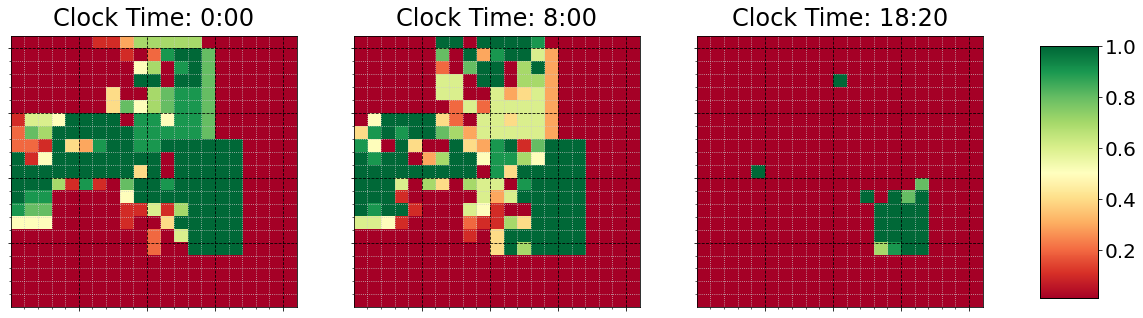

In [130]:
# Plotting Satisfaction for properties P1-P4
s_avg_files = list(map(lambda x: x.replace("r_", "s_"), avg_files))
for f in s_avg_files:
  multi_snap_printer(f, interesting_snaps, width=0.040, left=0.84, smax=1.0, smin=0.01, cmap='RdYlGn')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x288 with 0 Axes>

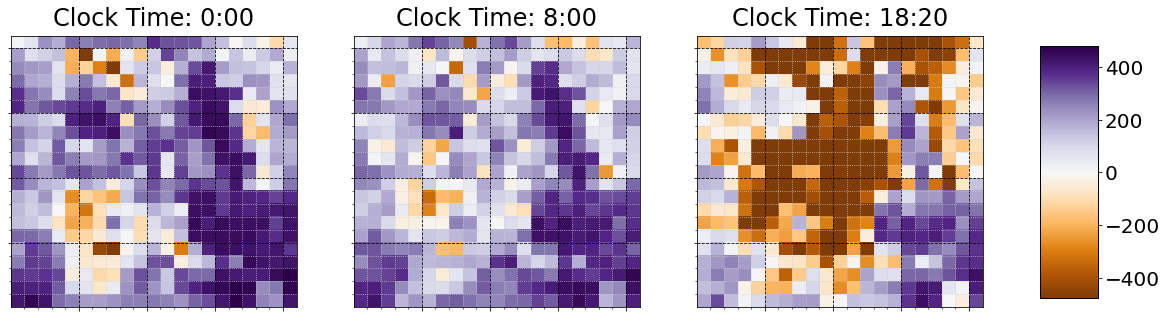

<Figure size 432x288 with 0 Axes>

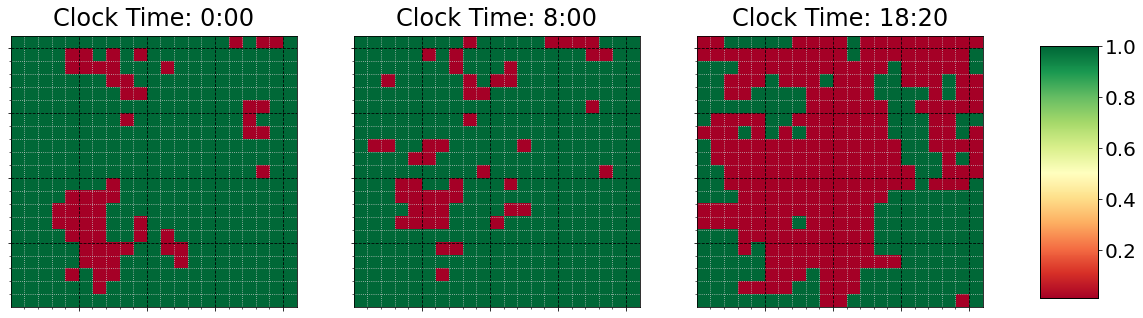

In [139]:
# Example plotting of specific trajectory, i.e. n.010
# Change the `pre` depending on the property, and the `n` depending on the trajectory
pre = "p1"
n = "010"
files = [f"{pre}/r_{n}_K500_grid_21x21_T_144", f"{pre}/s_{n}_K500_grid_21x21_T_144"]

multi_snap_printer(files[0], interesting_snaps, width=0.040, left=0.84, cmap='PuOr', symmetric=True)
multi_snap_printer(files[1], interesting_snaps, width=0.040, left=0.84, smax=1.0, smin=0.01, cmap='RdYlGn')

# Gifs generation

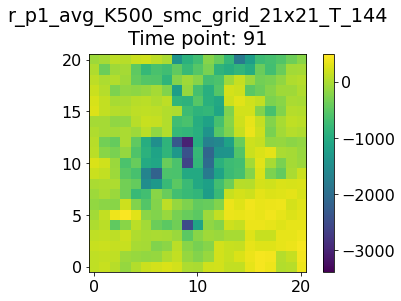

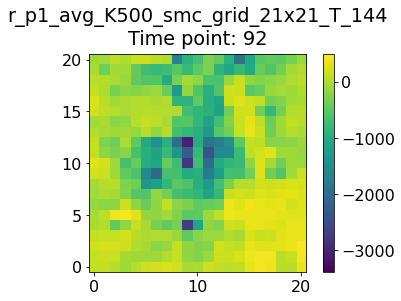

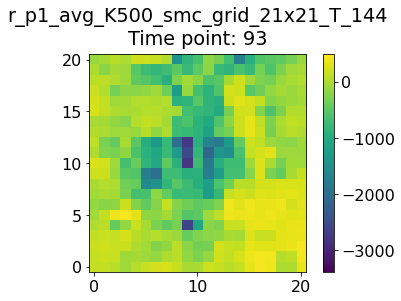

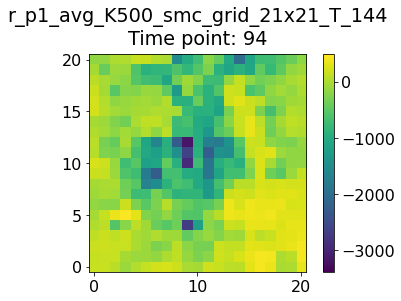

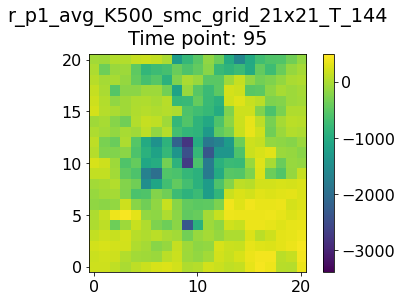

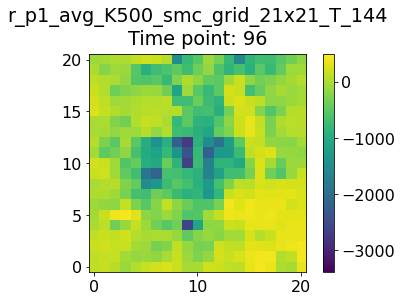

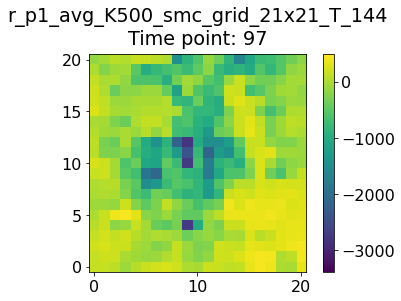

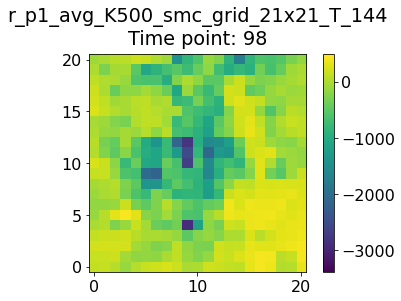

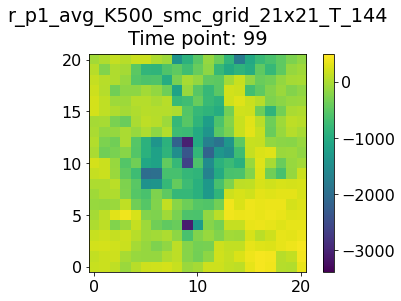

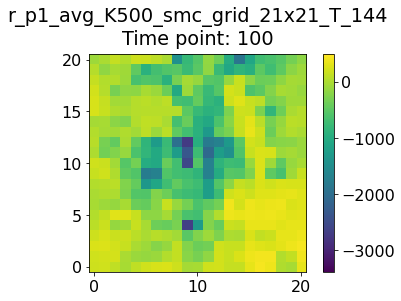

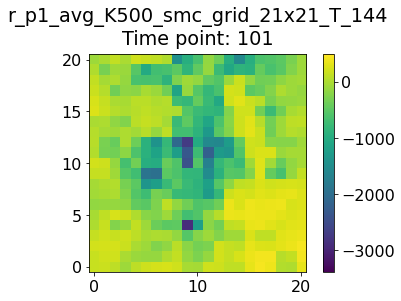

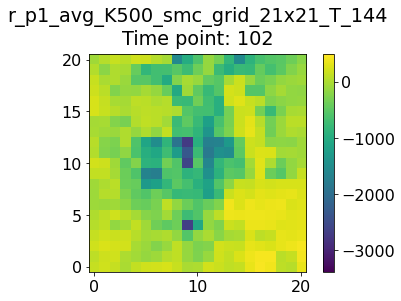

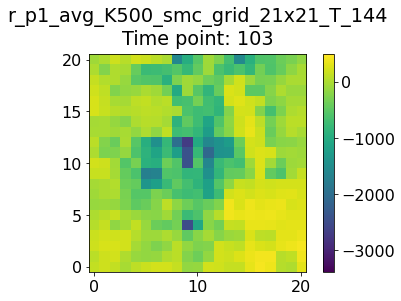

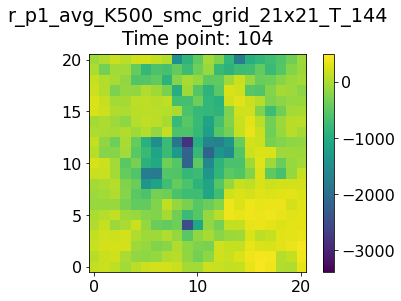

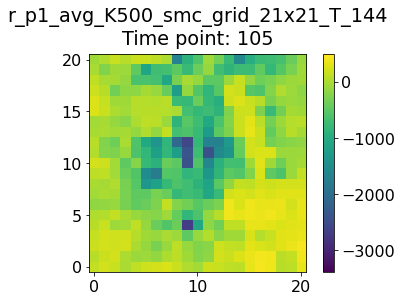

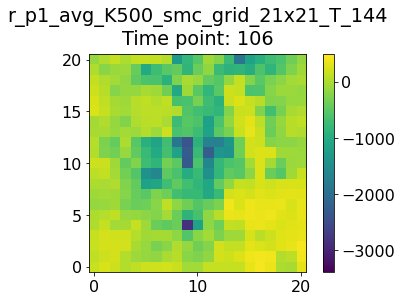

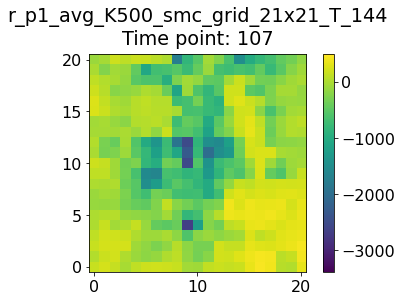

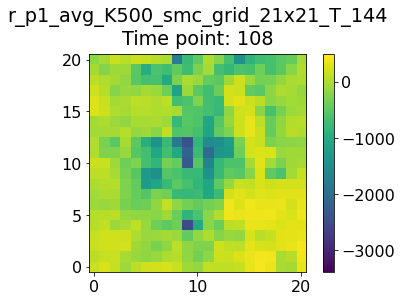

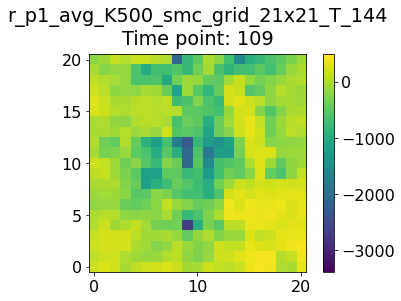

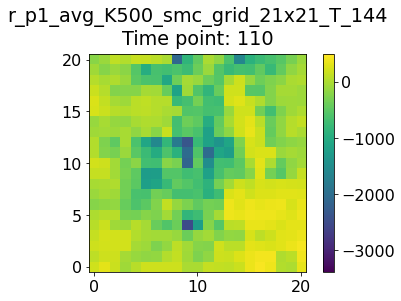

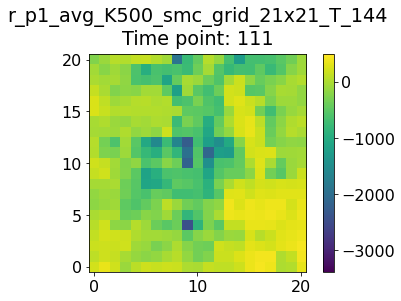

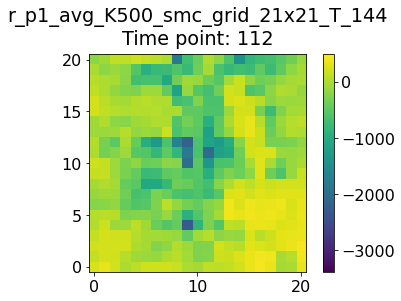

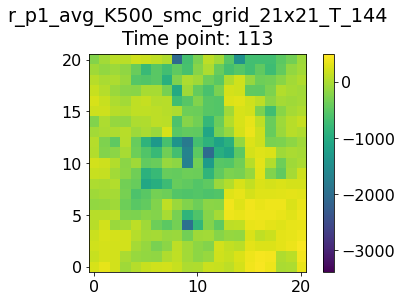

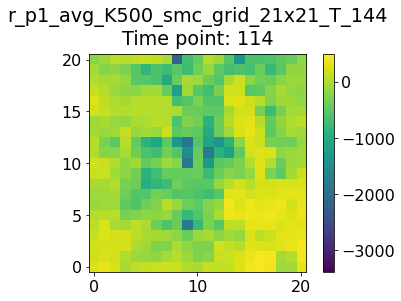

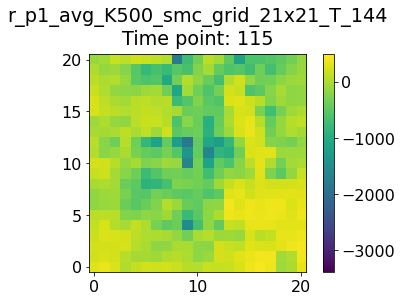

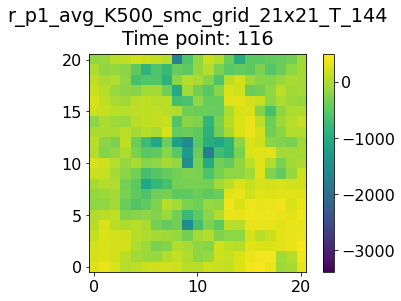

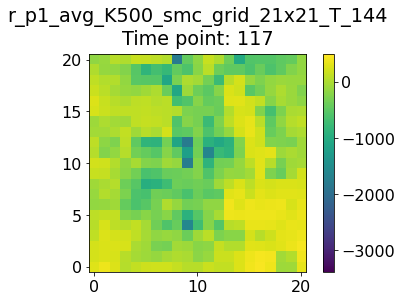

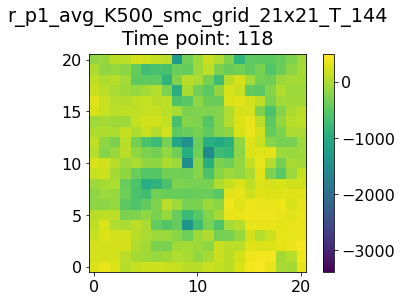

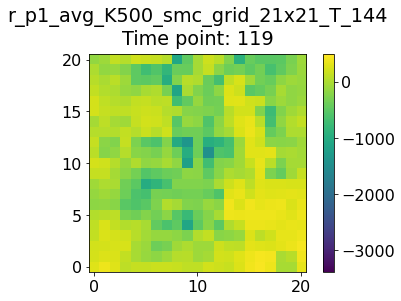

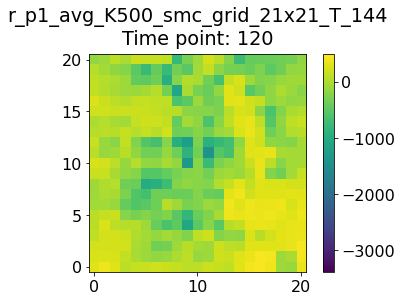

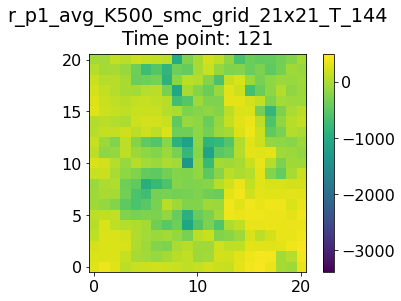

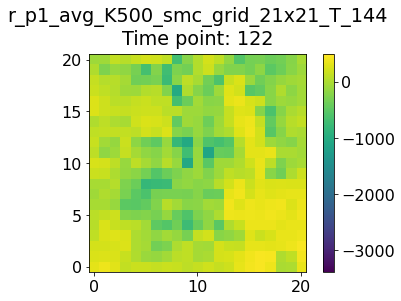

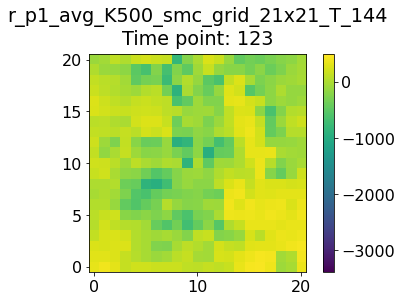

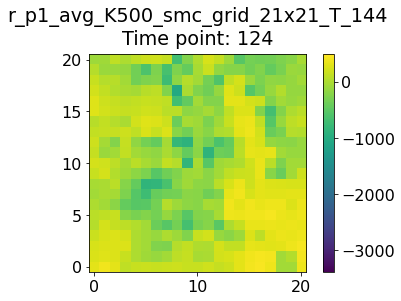

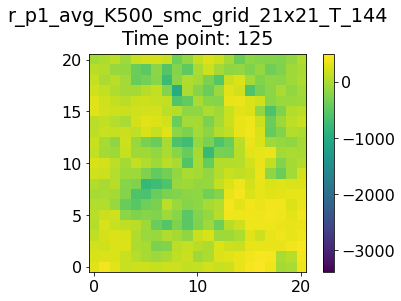

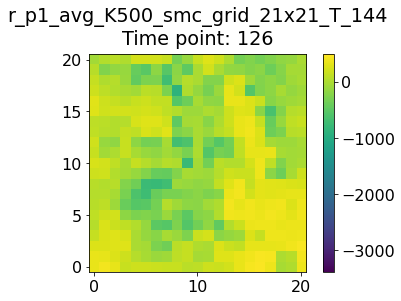

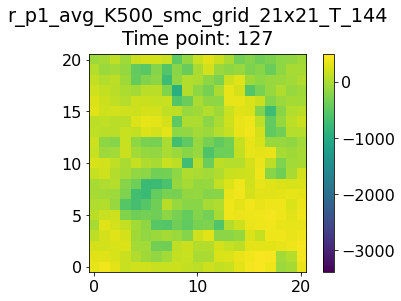

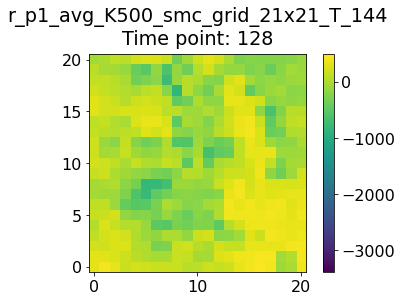

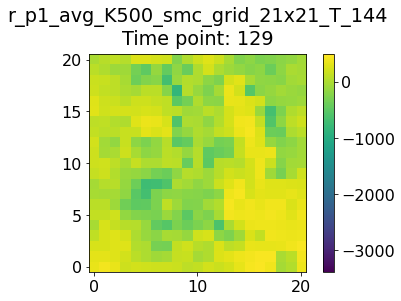

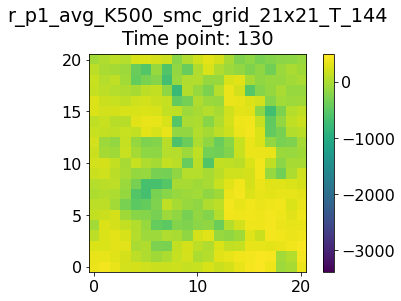

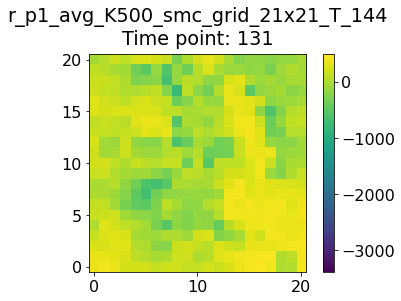

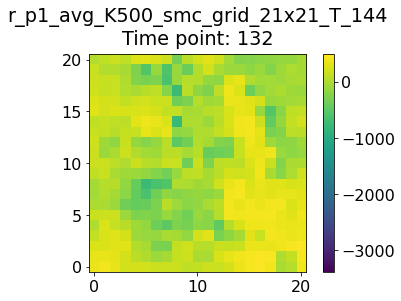

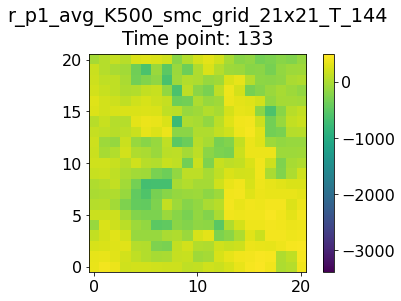

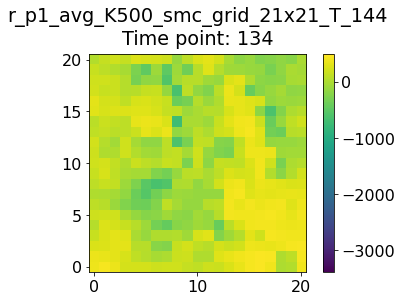

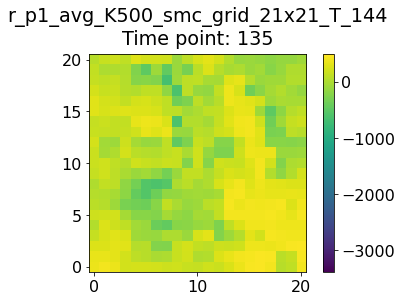

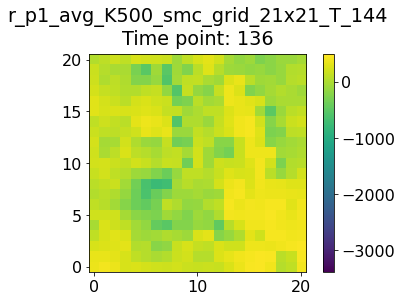

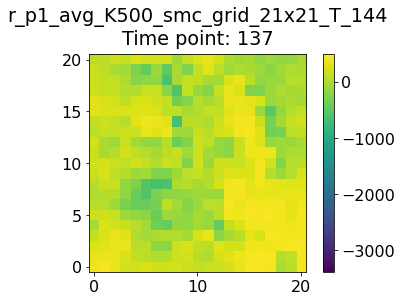

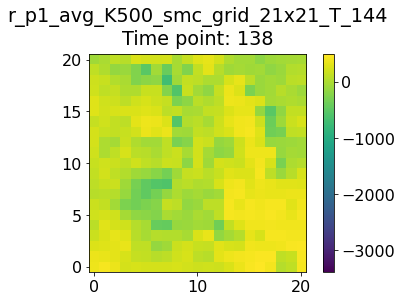

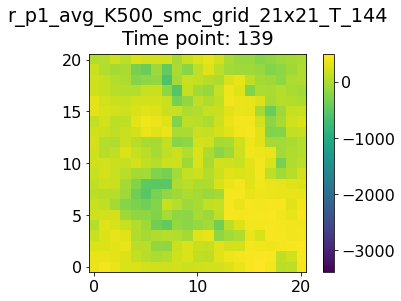

In [125]:
# INPUT GIF
filename = "input_avg_K0_smc_grid_21x21_T_144"
#generate_gif(filename)

# P1 GIF
prop = 'p1'
filename = "r_" + prop + "_avg_K500_smc_grid_21x21_T_144"

generate_gif(filename)

# P2' GIF
prop = 'p2'
filename = "r_" + prop + "_avg_K500_smc_grid_21x21_T_144"

generate_gif(filename)

# P3 GIF
prop = 'p3'
filename = "r_" + prop + "_avg_K500_smc_grid_21x21_T_144"

generate_gif(filename)

# Unused scripts that might be useful in future

In [ ]:
# Input Normalization (Enable when needed)
'''
# Input Normalization 
base = "_trajectories_grid_21x21_T_144" 
files = []
for i in range(1, 101):
    if i < 10:
        s = "00" + str(i)
    elif i < 100:
        s = "0" + str(i)
    else:
        s = str(i)
    files.append(s + base)

for f in files:
    df = pd.read_csv(path + directory + "/" + f + ".csv")
    df = qnorm.quantile_normalize(df)
    #df.drop(columns="", axis=1, inplace=True)
    df.to_csv(path + directory + "/norm/" + f + ".csv", index=False)
'''

In [ ]:
# Average & Variance Plotting
plot_multi(avg_files, maxcols=4)
plot_multi(var_files, maxcols=4)

input_trajectory = "data_matrix_20131111"

plot_graph(input_trajectory, path=abs_path + resources_dir, directory="")
plot_graph(input_trajectory, func=qnorm.quantile_normalize, path=abs_path + resources_dir, directory="")
plot_graph(input_trajectory, func=lambda x: qnorm.quantile_normalize(x.transpose()).transpose(), path=abs_path + resources_dir, directory="")

filename = "r_p3_avg_K500_smc_grid_21x21_T_144"

plot_graph(filename, index="Space", func=qnorm.quantile_normalize)
#plot_graph(filename, index="Space", func=lambda x: qnorm.quantile_normalize(x.transpose()).transpose())

# Normalized Input
#plot_multi(avg_files, directory=data_dir + "/norm", maxcols=4)
#plot_multi(var_files, directory=data_dir + "/norm", maxcols=4)

# Normalized Output
#plot_multi(avg_files, func=qnorm.quantile_normalize)
#plot_multi(var_files, func=qnorm.quantile_normalize)

In [ ]:
# Property P1 flat plotting..
plot_graph("r_p1_avg_K500_smc_grid_21x21_T_144", index="Space")

<Figure size 432x288 with 0 Axes>

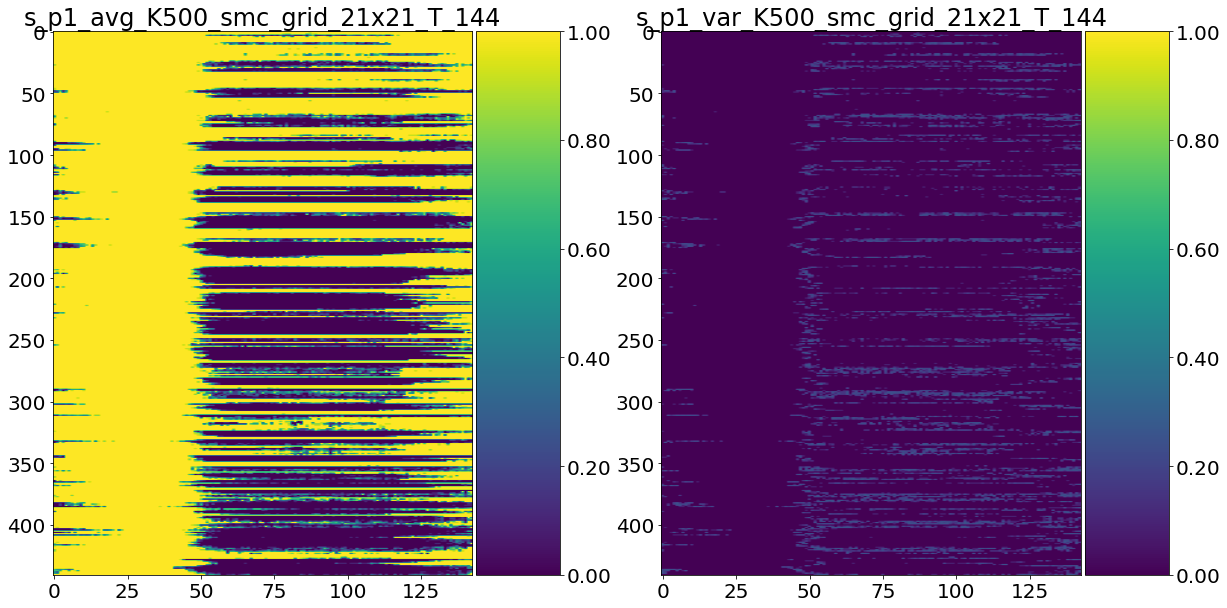

<Figure size 432x288 with 0 Axes>

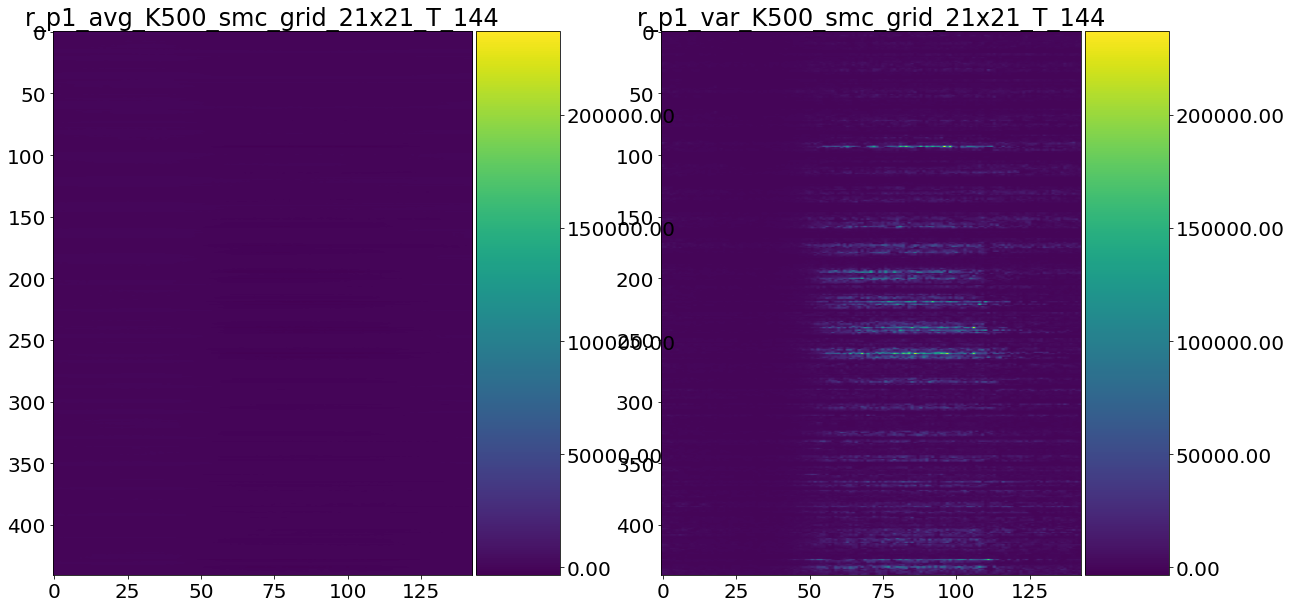

In [133]:
# Example of multiple plots...
s_p1 = ["s_p1_avg_K500_smc_grid_21x21_T_144", "s_p1_var_K500_smc_grid_21x21_T_144"] 
r_p1 = ["r_p1_avg_K500_smc_grid_21x21_T_144", "r_p1_var_K500_smc_grid_21x21_T_144"]

plot_multi(s_p1)
plot_multi(r_p1)

<Figure size 432x288 with 0 Axes>

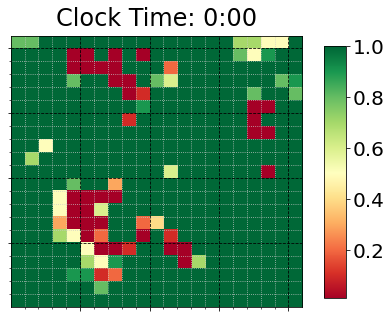

<Figure size 432x288 with 0 Axes>

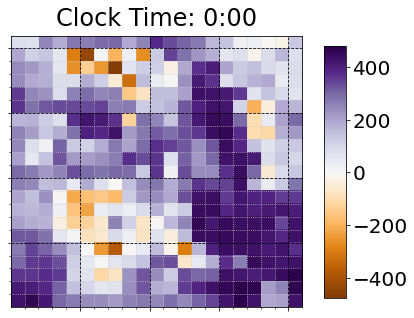

In [134]:
multi_snap_printer(s_p1[0], [1], maxcols=1, smax=1.0, smin=0.01, cmap='RdYlGn')
multi_snap_printer(r_p1[0], [1], maxcols=1, cmap='PuOr', symmetric=True)